# Pattern recognition in birdsong production

In [1]:
import numpy               as np
import matplotlib.pyplot   as plt
import persim
from mpl_toolkits.mplot3d  import Axes3D
from ripser                import Rips
from src.distance          import *
from src.dynamical_systems import *
from scipy.signal          import find_peaks

### 1. Time series

Load the record of the air sac pressure of a canary during singing.

In [2]:
s = np.loadtxt('data/pressure.txt')
len(s)

333871

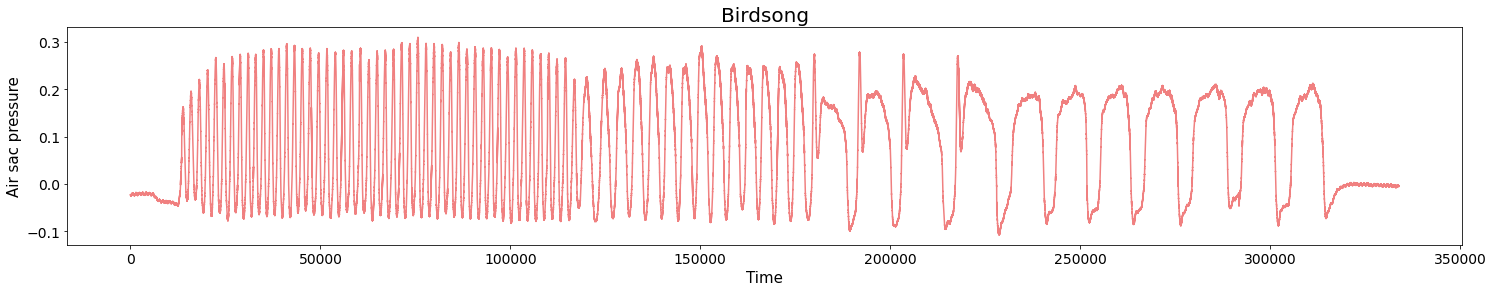

In [3]:
plt.figure(figsize=(25,4))
plt.ylabel('Air sac pressure', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Birdsong', fontsize = 20)
plt.plot(s, color = 'lightcoral');

### 2. Delay embedding

We compute the delay embedding of this time series

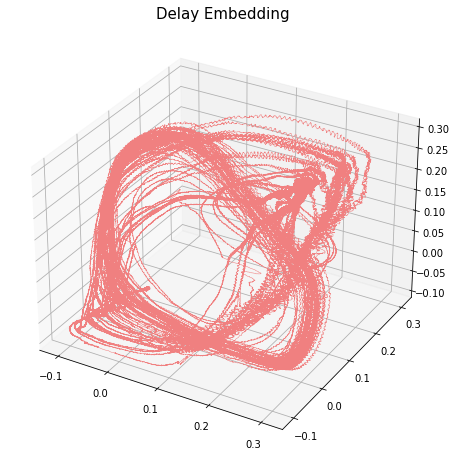

In [4]:
T = 500 # time delay
D = 3  # embedding dimension
embedding = delay_embedding(s, T, D)
plot_trajectories(embedding[0], embedding[1], embedding[2], 'Delay Embedding', 'line')

We consider a subsample of ~ 3000 points of the original pointcloud (~ 300000 points)

In [5]:
stride = 100
embedding_sub = np.stack([embedding[0][::stride], embedding[1][::stride], embedding[2][::stride]]).T

### 3. Persistence diagram 

We compute the persistence diagram of the subsample using Fermat distance.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


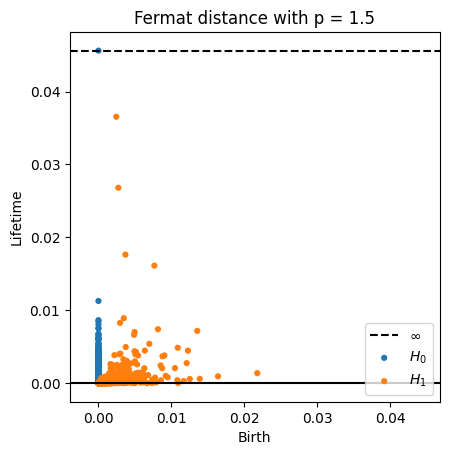

In [9]:
p=1.5
dgm = Fermat_dgm(embedding_sub, p)

An interpretation of the four salient generators is in Section 4.

### 4. Time evolving persistence diagrams

In [ ]:
# Compute persistent diagrams of time evolving delay embeddings
diagrams = {}
rips = Rips()
distance = compute_fermat_distance(embedding_sub, 1.5)
for t in range(1, len(embedding_sub.T)):
    diagrams[t] = rips.fit_transform(distance[:t, :t], distance_matrix = True)[1]
#np.save('data/birdsong_diagrams.npy', diagrams) 

In [8]:
# Load diagrams
diagrams = np.load('data/birdsong_diagrams.npy', allow_pickle='TRUE').item()

In [ ]:
# Compute consecutive bottleneck distances
bottleneck_distances = {}
step= 1
for t in np.arange(2*step,len(embedding_sub), step):
    bottleneck_distances[t] = persim.bottleneck(diagrams[t], diagrams[t-step])
np.save('data/birdsong_bd_diagrams.npy', bottleneck_distances) 

In [11]:
# Load series of bottleneck distances
bottleneck_distances = np.load('data/birdsong_bd_diagrams.npy', allow_pickle='TRUE').item()

In [13]:
# Compute peaks of moving average of the series of consecutive bottleneck distances
bd_series = np.array(list(bottleneck_distances.values()))
ma  = moving_average(bd_series, 5)
peaks, properties = find_peaks(ma, prominence=0.001, distance=150)

In [17]:
stride = 100
step = 5
D = 3
window_ma = 5
t0 = (D-1)*stride*step+window_ma*stride
xmin = -15000
xmax = 350000

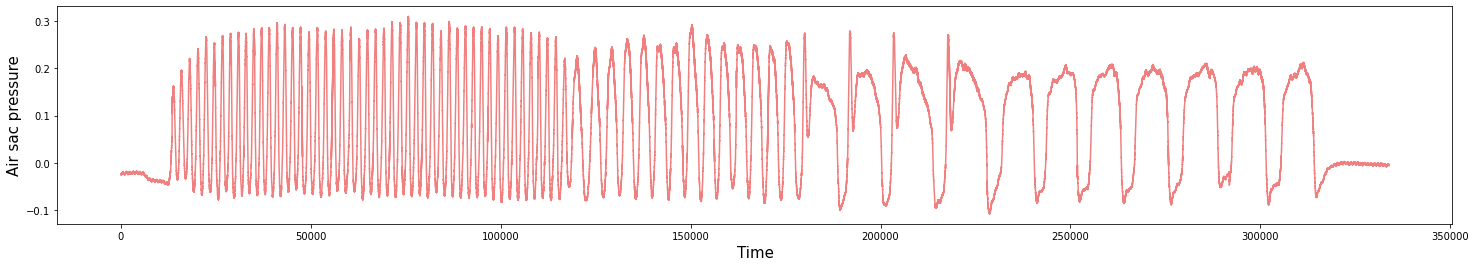

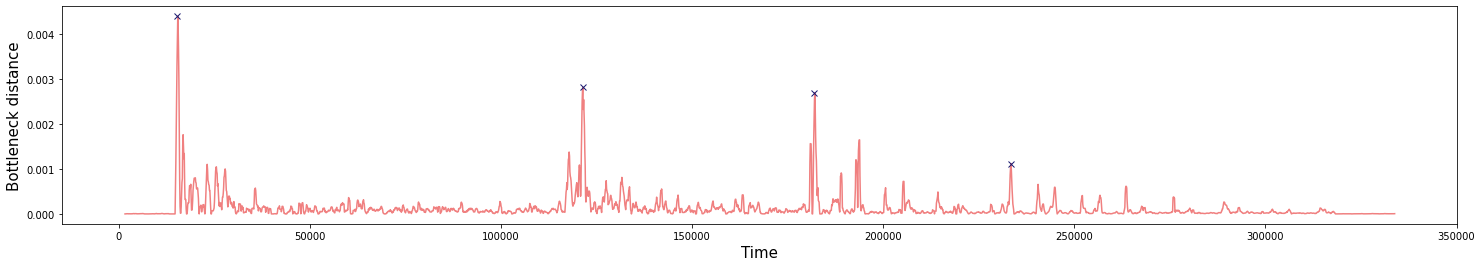

In [27]:
# Plot original time series vs moving average of the series of consecutive bottleneck distances
fig, ax = plt.subplots(figsize=(25,4))
plt.ylabel('Air sac pressure', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
ax.plot(s, color = 'lightcoral');

fig, ax = plt.subplots(figsize=(25,4))
ax.set(xlim=(xmin, xmax))
plt.ylabel('Bottleneck distance', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
ax.plot(np.arange(t0+stride, len(s), stride), ma, color = 'lightcoral')
ax.plot(peaks*stride+t0, ma[peaks], 'x', color = 'midnightblue');

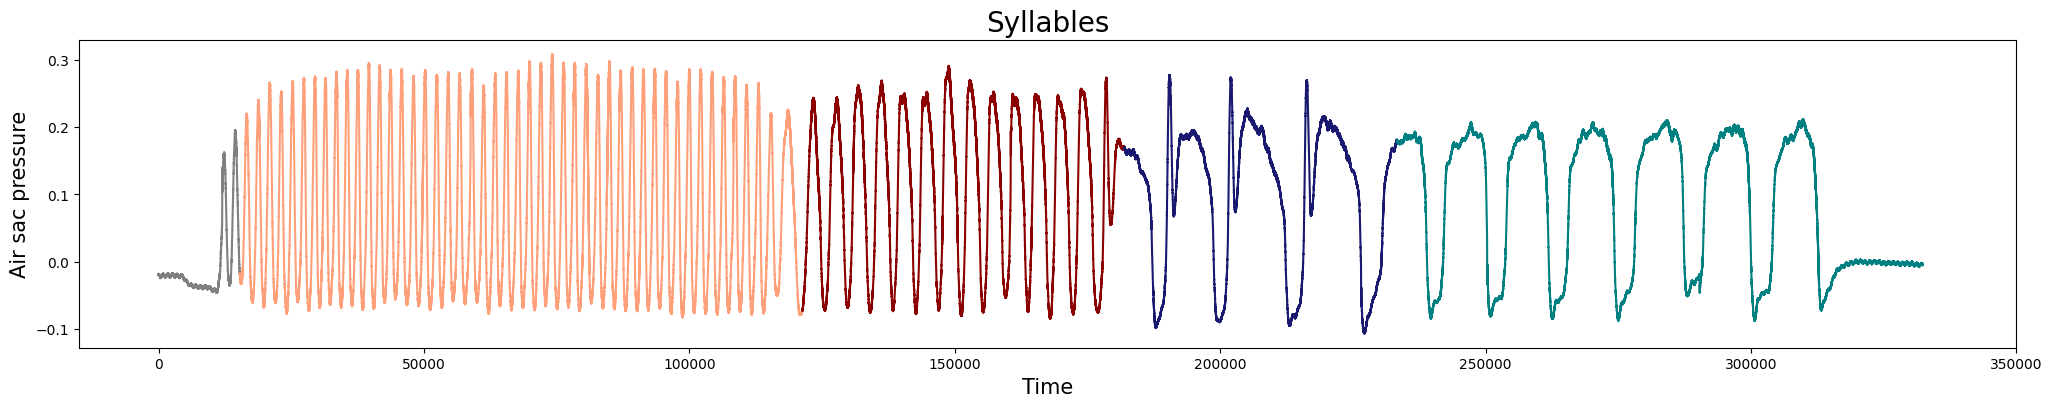

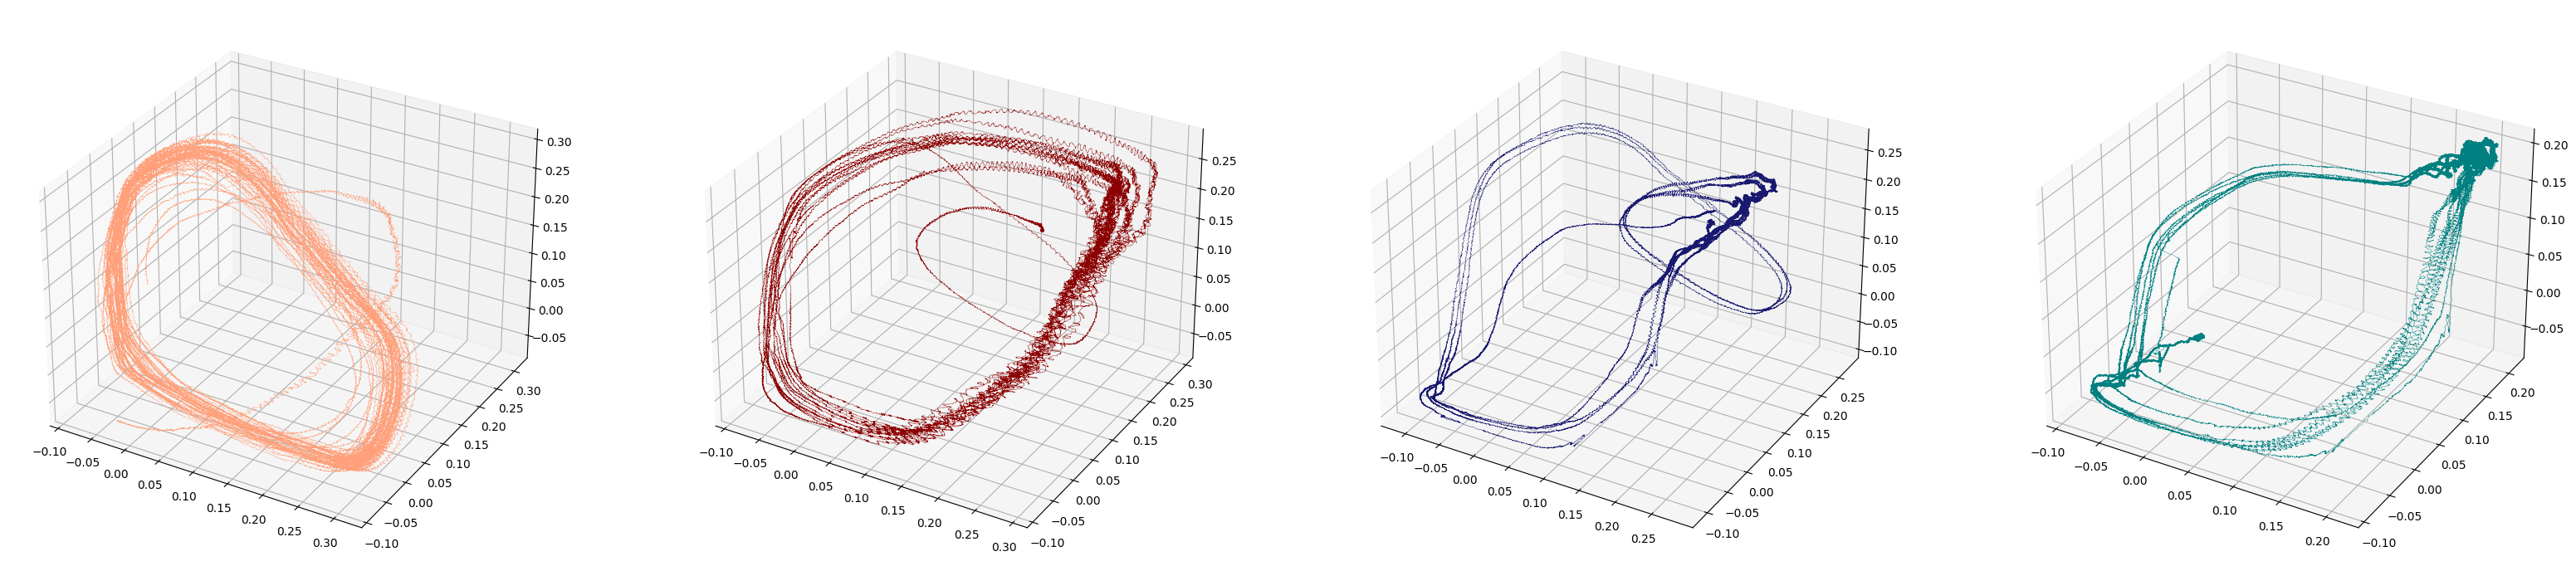

In [33]:
# Plot cuts induced by prominent peaks (followed by exponential decay) in the series of consecutive bottleneck distances.
s0 = s[t0:]
cuts = [0] + list(peaks*stride+t0) + [len(s0)]
color = ['grey', 'lightsalmon', 'darkred', 'midnightblue', 'teal']

fig, ax = plt.subplots(figsize=(25,4))
ax.set(xlim=(xmin, xmax))
plt.ylabel('Air sac pressure', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.title('Syllables', fontsize = 20)

for i in range(5):
    ax.plot(range(cuts[i],cuts[i+1]), s0[cuts[i]:cuts[i+1]], color = color[i])
plt.show()

fig = plt.figure(figsize=(50,9))
subplot = [111,112,113,114]
T = 500
d = 3
for i in range(1,5):
    X = delay_embedding(s0[cuts[i]:cuts[i+1]], T, d)
    ax = fig.add_subplot(1,5,i+1, projection = '3d')
    ax.plot(X[0], X[1], X[2], lw=0.3, color = color[i])
    plt.tick_params(labelsize=10)
plt.show()